In [1]:
import torch
import torchvision 
import os
from torch.utils import data
from PIL import Image
import torchvision.datasets as dset
import numpy as np

import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from tqdm.notebook import tqdm
import torchvision.models as models
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import matplotlib.pyplot as plt
import math
import pickle
from torchsummary import summary
from math import ceil
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#vital params



dataset_name="cifar10"
 
model_name="EfficientNetb1_sp"
version = "b1"

base_model = [
    # expand_ratio, channels, repeats, stride, kernel_size
    [1, 16, 1, 1, 3],
    [6, 24, 2, 2, 3],
    [6, 40, 2, 2, 5],
    [6, 80, 3, 2, 3],
    [6, 112, 3, 1, 5],
    [6, 192, 4, 2, 5],
    [6, 320, 1, 1, 3],
]

phi_values = {
    # tuple of: (phi_value, resolution, drop_rate)
    "b0": (0, 224, 0.2),  # alpha, beta, gamma, depth = alpha ** phi
    "b1": (0.5, 240, 0.2),
    "b2": (1, 260, 0.3),
    "b3": (2, 300, 0.3),
    "b4": (3, 380, 0.4),
    "b5": (4, 456, 0.4),
    "b6": (5, 528, 0.5),
    "b7": (6, 600, 0.5),
}

phi, res, drop_rate = phi_values[version]
#hyperparameters
batch_size=20
num_classes=-1
learning_rate=0.001
image_size=(res,res)

if dataset_name == "tsrd":
    num_classes=58
elif dataset_name == "cifar10":
    num_classes=10


print("Model: "+model_name +" with {} classes".format(num_classes)+
      " running on: "+dataset_name)
print("The input image size is:{}".format(image_size))

Model: EfficientNetb1_sp with 10 classes running on: cifar10
The input image size is:(240, 240)


In [2]:
# load data through imagefolder
if dataset_name == "tsrd":
    main_transforms=transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406] , std = [0.229, 0.224, 0.225]),

    ])

    train_dir = "../../dataset/data"
    head_train_set = dset.ImageFolder(train_dir,transform=main_transforms)
    train_set, valid_set = data.random_split(head_train_set, [5000, 998])
    train_set, test_set = data.random_split(train_set,[4000, 1000])


    train_dataloader=torch.utils.data.DataLoader(train_set,
                                                 batch_size=batch_size,
                                                 shuffle=True)

    val_dataloader=torch.utils.data.DataLoader(valid_set,
                                                 batch_size=batch_size,
                                                 shuffle=True)

    test_dataloader=torch.utils.data.DataLoader(test_set,
                                                 batch_size=1,
                                                 shuffle=True)
    print(head_train_set.class_to_idx)
elif dataset_name == "cifar10":
    
    main_transforms=transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.5, 0.5, 0.5] , std = [0.5, 0.5, 0.5]),

    ])

    bigtrain_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=main_transforms)
    train_set, valid_set = data.random_split(bigtrain_set, [40000, 10000])
    test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=main_transforms)


    train_dataloader = torch.utils.data.DataLoader(train_set, 
                                                   batch_size=batch_size, 
                                                   shuffle=True, num_workers=2)

    val_dataloader = torch.utils.data.DataLoader(valid_set, 
                                                   batch_size=batch_size, 
                                                   shuffle=True, num_workers=2)

    test_dataloader = torch.utils.data.DataLoader(test_set,
                                                  batch_size=batch_size,
                                                  shuffle=False, num_workers=2)
    





print("Dataset size: Train: {}, Valid: {}, Test: {}"
      .format(len(train_set),len(valid_set),len(test_set)))


print(train_set[0][0].shape)
print("Datasets loaded and prepared")

Files already downloaded and verified
Files already downloaded and verified
Dataset size: Train: 40000, Valid: 10000, Test: 10000
torch.Size([3, 240, 240])
Datasets loaded and prepared


In [3]:
class CNNBlock(nn.Module):
    def __init__(
            self, in_channels, out_channels, kernel_size, stride, padding, groups=1
    ):
        super(CNNBlock, self).__init__()
        self.cnn = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            groups=groups,
            bias=False,
        )
        self.bn = nn.BatchNorm2d(out_channels)
        self.silu = nn.SiLU() # SiLU <-> Swish

    def forward(self, x):
        return self.silu(self.bn(self.cnn(x)))

class SqueezeExcitation(nn.Module):
    def __init__(self, in_channels, reduced_dim):
        super(SqueezeExcitation, self).__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), # C x H x W -> C x 1 x 1
            nn.Conv2d(in_channels, reduced_dim, 1),
            nn.SiLU(),
            nn.Conv2d(reduced_dim, in_channels, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return x * self.se(x)

class InvertedResidualBlock(nn.Module):
    def __init__(
            self,
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            expand_ratio,
            reduction=4, # squeeze excitation
            survival_prob=0.8, # for stochastic depth
    ):
        super(InvertedResidualBlock, self).__init__()
        self.survival_prob = 0.8
        self.use_residual = in_channels == out_channels and stride == 1
        hidden_dim = in_channels * expand_ratio
        self.expand = in_channels != hidden_dim
        reduced_dim = int(in_channels / reduction)

        if self.expand:
            self.expand_conv = CNNBlock(
                in_channels, hidden_dim, kernel_size=3, stride=1, padding=1,
            )

        self.conv = nn.Sequential(
            CNNBlock(
                hidden_dim, hidden_dim, kernel_size, stride, padding, groups=hidden_dim,
            ),
            SqueezeExcitation(hidden_dim, reduced_dim),
            nn.Conv2d(hidden_dim, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

    def stochastic_depth(self, x):
        if not self.training:
            return x

        binary_tensor = torch.rand(x.shape[0], 1, 1, 1, device=x.device) < self.survival_prob
        return torch.div(x, self.survival_prob) * binary_tensor

    def forward(self, inputs):
        x = self.expand_conv(inputs) if self.expand else inputs

        if self.use_residual:
            return self.stochastic_depth(self.conv(x)) + inputs
        else:
            return self.conv(x)


class EfficientNet(nn.Module):
    def __init__(self, version, num_classes):
        super(EfficientNet, self).__init__()
        width_factor, depth_factor, dropout_rate = self.calculate_factors(version)
        last_channels = ceil(1280 * width_factor)
        self.localization = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(31360, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.features = self.create_features(width_factor, depth_factor, last_channels)
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(last_channels, num_classes),
        )
        


        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    # Spatial transformer network forward function
    def stn(self, x):
        
        xs = self.localization(x)
        xs = xs.view(-1, 10*56*56)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)
        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)
        
        
    def calculate_factors(self, version, alpha=1.2, beta=1.1):
        phi, res, drop_rate = phi_values[version]
        depth_factor = alpha ** phi
        width_factor = beta ** phi
        return width_factor, depth_factor, drop_rate

    def create_features(self, width_factor, depth_factor, last_channels):
        channels = int(32 * width_factor)
        features = [CNNBlock(3, channels, 3, stride=2, padding=1)]
        in_channels = channels

        for expand_ratio, channels, repeats, stride, kernel_size in base_model:
            out_channels = 4*ceil(int(channels*width_factor) / 4)
            layers_repeats = ceil(repeats * depth_factor)

            for layer in range(layers_repeats):
                features.append(
                    InvertedResidualBlock(
                        in_channels,
                        out_channels,
                        expand_ratio=expand_ratio,
                        stride = stride if layer == 0 else 1,
                        kernel_size=kernel_size,
                        padding=kernel_size//2, # if k=1:pad=0, k=3:pad=1, k=5:pad=2
                    )
                )
                in_channels = out_channels

        features.append(
            CNNBlock(in_channels, last_channels, kernel_size=1, stride=1, padding=0)
        )

        return nn.Sequential(*features)

    def forward(self, x):
        self.stn(x)
        x = self.pool(self.features(x))
        
        return self.classifier(x.view(x.shape[0], -1))


def test():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    version = "b1"
    phi, res, drop_rate = phi_values[version]
    num_examples = 3
    x = torch.randn((num_examples, 3, res, res)).to(device)
    model = EfficientNet(
        version=version,
        num_classes=num_classes,
    ).to(device)
    print(x.shape)
    print(model(x).shape) # (num_examples, num_classes)

test()

#print("Efficient Net model defined")

torch.Size([3, 3, 240, 240])
torch.Size([3, 10])


C:\Users\2080Ti\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:4044: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
C:\Users\2080Ti\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:3982: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


In [5]:
model = EfficientNet(
    version=version,
    num_classes=num_classes,
).to(device)

model = model.to(device)

from thop import profile
import colorama
from colorama import Fore,Style
#vital params
def getGFLOPS(test_model):
    model=test_model.to(device)
    input = torch.randn(1, 3, res, res).to(device)
    macs, params = profile(model, inputs=(input, ))

    print(Fore.BLUE + "The model requires: {:.4f} GFLOPS".format(macs/1000_000_000))
    print(Style.RESET_ALL)
    return macs
getGFLOPS(model)

#pretesting model for shape
x=torch.randn(batch_size,3,res,res)
x=x.to(device)
print(x.shape)
print(model(x).shape)
print(summary(model, input_size=(3, res, res)))
print("model shape ready")

#initailise network


#loss and optimizer
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=learning_rate)

print("model initialised")

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_bn() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.SiLU'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.CNNBlock'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Sigmoid'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.SqueezeExcitation'>. Treat it as zero 

C:\Users\2080Ti\Anaconda3\envs\pytorch\lib\site-packages\torch\_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ..\aten\src\ATen\native\BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 234, 234]           1,184
         MaxPool2d-2          [-1, 8, 117, 117]               0
              ReLU-3          [-1, 8, 117, 117]               0
            Conv2d-4         [-1, 10, 113, 113]           2,010
         MaxPool2d-5           [-1, 10, 56, 56]               0
              ReLU-6           [-1, 10, 56, 56]               0
            Linear-7                   [-1, 32]       1,003,552
              ReLU-8                   [-1, 32]               0
            Linear-9                    [-1, 6]             198
           Conv2d-10         [-1, 33, 120, 120]             891
      BatchNorm2d-11         [-1, 33, 120, 120]              66
             SiLU-12         [-1, 33, 120, 120]               0
         CNNBlock-13         [-1, 33, 120, 120]               0
           Conv2d-14         [-1, 33, 1

In [5]:
# This is the testing part
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp
get_n_params(model)

def test(model, test_loader, istest= False, doprint=True):
    model.eval()
    test_loss = 0
    correct = 0
    TP=0
    TN=0
    FN=0
    FP=0
    test_loss = 0.0
    
    with torch.no_grad(): # disable gradient calculation for efficiency
        for data, target in tqdm(test_loader):
            # Prediction
            data=data.to(device=device)
            target=target.to(device=device)
            optimizer.zero_grad()
            
            output = model(data)
            loss=criterion(output,target)
            
            # Compute loss & accuracy
            test_loss+=loss.item()*data.size(0)

            
            #test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item() # how many predictions in this batch are correct
            
            #print("pred={} , target={} , judge={}".format(pred.item(),target.item(),pred.eq(target.view_as(pred)).sum().item()))

            
    #test_loss /= len(test_loader.dataset)

        
    # Log testing info
    if istest and doprint:
        
        print('Loss: {}   Accuracy: {}/{} ({:.3f}%)'.format(test_loss,
        correct, len(test_loader.dataset),
        100.000 * correct / len(test_loader.dataset)))
        print("Total parameters: {}".format(get_n_params(model)))
    elif doprint:
        print('Accuracy: {}/{} ({:.3f}%)'.format(
        correct, len(test_loader.dataset),
        100.000 * correct / len(test_loader.dataset)))
    return 100.000 * correct / len(test_loader.dataset)
        

print("test defined")

def testshouldearlystop(acclist,minepoch,epochwindow,accwindow):
    runlen=len(acclist)
    if(runlen<minepoch):
        return False
    elif(acclist[-1]>acclist[-2]):
        return False
    
    watchwindow=acclist[-epochwindow:]
    shouldjump=True
    sum=0
    for i in watchwindow:
        sum+=i
    avg = sum/epochwindow
    for i in watchwindow:
        if abs(i-avg)>(accwindow):
            shouldjump=False
    return shouldjump
print("early stop defined")

test defined
early stop defined


In [6]:
now=datetime.now()
dt_string = now.strftime("%Y%m%d%H%M%S")

tensorboard_string="runs/"+model_name+dt_string
grandstore_string="grandstore/"+dataset_name+"_"+model_name+dt_string+".pkl"
print("tensorboard_string:")
print(tensorboard_string)
print("grandstore_string:")
print(grandstore_string)


writer = SummaryWriter(tensorboard_string)


tensorboard_string:
runs/EfficientNetb1_sp20211106191411
grandstore_string:
grandstore/cifar10_EfficientNetb1_sp20211106191411.pkl


In [7]:
#This is the training part

# Grand_store={
#     'total_epoch_run':-1
#     'topmodels':-1
#     'lastmodel':-1
#     'acclog':[]
#     'maxacc':-1
#     'minacc':101
# }
# train_epoch={
#     "numofepoch":-1
#     "accuracy":-1
#     "model_state":model.state_dict(),
#     "optim_state":optimizer.state_dict(),
#     "totaltrain_loss":totaltrain_loss,
#     "totalvalid_loss":totalvalid_loss
# }

def training(max_epoch=120, top_accuracy_track=3, grandstore={},
             minepoch=30,epochwindow=10,accwindow=0.35):

    grandstore['total_epoch_run']=0
    grandstore['topmodels']=[]
    grandstore['acclog']=[]
    grandstore['maxacc']=-1
    grandstore['minacc']=101
    
    for epoch in range(0,max_epoch):
        
        grandstore['total_epoch_run']=epoch+1
        
        train_epoch={
        "numofepoch":grandstore['total_epoch_run']
        }
    
        train_loss=0.0
        valid_loss=0.0
        print("Running epoch: {}".format(epoch+1))

        model.train()
        totaltrain_loss=0
        
        #this is the training part
        for data,target in tqdm(train_dataloader):
            data=data.to(device=device)
            target=target.to(device=device)
            output = model(data)
            loss = criterion(output, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*data.size(0)
            totaltrain_loss += train_loss

        #this is the validation part
        model.eval()
        totalvalid_loss=0;
        correct = 0
        for data,target in tqdm(val_dataloader):
            data=data.to(device=device)
            target=target.to(device=device)
            output=model(data)
            loss=criterion(output,target)
            valid_loss=loss.item()*data.size(0)
            #train_loss = train_loss/len(train_dataloader.dataset)
            #valid_loss = valid_loss/len(val_dataloader.dataset)
            totalvalid_loss+=valid_loss
            
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item() # how many predictions in t
        

        training_accuracy=100. * correct / len(val_dataloader.dataset)
        train_epoch["accuracy"]=training_accuracy
        train_epoch["totaltrain_loss"]=totaltrain_loss
        train_epoch["totalvalid_loss"]=totalvalid_loss
        
        #writings to the GrandStore
        
        grandstore['acclog'].append(training_accuracy)
        
        if training_accuracy < grandstore['minacc']:
            grandstore['minacc'] = training_accuracy
            
        if training_accuracy > grandstore['maxacc']:
            grandstore['maxacc'] = training_accuracy
        

        if epoch < top_accuracy_track:
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['topmodels'].append((training_accuracy,thisepochtestresult,epoch+1,train_epoch))
            #if error print this
            grandstore['topmodels'].sort()

        elif training_accuracy > grandstore['topmodels'][0][0]:
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['topmodels'][0]=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)
            #if error print this
            grandstore['topmodels'].sort()

        if epoch == (max_epoch-1):
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['lastmodel']=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)
                     
        writer.add_scalar('Training Loss',totaltrain_loss,global_step = epoch)
        writer.add_scalar('Valid Loss',totalvalid_loss,global_step = epoch)
        writer.add_scalar('Accuracy',training_accuracy,global_step = epoch)
        
        print('Accuracy: {:.3f}'.format(training_accuracy))
        print('Training Loss: {:.4f} \tValidation Loss: {:.4f}\n'.format(totaltrain_loss, totalvalid_loss))
        
        #early stopping criteria
        if(testshouldearlystop(acclist=grandstore['acclog'],
                               minepoch = minepoch,
                               epochwindow = epochwindow,
                               accwindow = accwindow)):
            print("early stop occured!!")
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['lastmodel']=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)
            return grandstore
    
    return grandstore
        


In [8]:
TOP_ACCURACY_TRACK = 5
# max_epoch=120, top_accuracy_track=3, grandstore={},
# minepoch=30,epochwindow=10,accwindow=0.35

Grandstore=training(max_epoch=240,
                    minepoch=150,
                    top_accuracy_track=TOP_ACCURACY_TRACK,
                    epochwindow=10,
                    accwindow=0.25                  
                   )

Running epoch: 1


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 43.320
Training Loss: 78949514.7244 	Validation Loss: 15328.4715

Running epoch: 2


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 61.640
Training Loss: 55643427.4578 	Validation Loss: 10480.0340

Running epoch: 3


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 70.100
Training Loss: 41161600.4011 	Validation Loss: 8564.4630

Running epoch: 4


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 77.350
Training Loss: 32764681.3789 	Validation Loss: 6502.4255

Running epoch: 5


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 78.770
Training Loss: 27138082.3091 	Validation Loss: 6228.9448

Running epoch: 6


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 80.540
Training Loss: 23038424.0693 	Validation Loss: 5645.2629

Running epoch: 7


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 82.570
Training Loss: 20165969.9356 	Validation Loss: 5162.6176

Running epoch: 8


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 83.000
Training Loss: 17159987.7373 	Validation Loss: 5023.7384

Running epoch: 9


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.080
Training Loss: 14734499.4730 	Validation Loss: 4882.7761

Running epoch: 10


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 83.790
Training Loss: 12260566.8043 	Validation Loss: 5007.2216

Running epoch: 11


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 83.880
Training Loss: 10476049.5745 	Validation Loss: 5318.2025

Running epoch: 12


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.290
Training Loss: 8916556.1841 	Validation Loss: 5267.8263

Running epoch: 13


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.870
Training Loss: 7811395.4610 	Validation Loss: 5223.7087

Running epoch: 14


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 83.460
Training Loss: 6703664.1322 	Validation Loss: 6010.8927

Running epoch: 15


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.670
Training Loss: 5832484.3923 	Validation Loss: 5987.0590

Running epoch: 16


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.820
Training Loss: 5194849.8441 	Validation Loss: 5984.0863

Running epoch: 17


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 83.390
Training Loss: 4763394.7901 	Validation Loss: 6451.7440

Running epoch: 18


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.380
Training Loss: 4370296.1968 	Validation Loss: 6348.7315

Running epoch: 19


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.730
Training Loss: 3997922.0571 	Validation Loss: 6307.0052

Running epoch: 20


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.230
Training Loss: 3903128.4667 	Validation Loss: 6622.0326

Running epoch: 21


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.200
Training Loss: 3375995.3321 	Validation Loss: 6449.2022

Running epoch: 22


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.170
Training Loss: 3437322.6999 	Validation Loss: 6649.4862

Running epoch: 23


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.450
Training Loss: 2964697.8916 	Validation Loss: 6859.5584

Running epoch: 24


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.700
Training Loss: 2998294.9053 	Validation Loss: 6651.3373

Running epoch: 25


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.840
Training Loss: 2731361.7579 	Validation Loss: 7026.8218

Running epoch: 26


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.510
Training Loss: 2417921.8130 	Validation Loss: 6912.1157

Running epoch: 27


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.570
Training Loss: 2395659.5102 	Validation Loss: 6628.9984

Running epoch: 28


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.250
Training Loss: 2434721.6841 	Validation Loss: 6898.1732

Running epoch: 29


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.460
Training Loss: 2415274.0775 	Validation Loss: 6711.8942

Running epoch: 30


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.200
Training Loss: 2072567.4337 	Validation Loss: 6620.8509

Running epoch: 31


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.390
Training Loss: 2146199.1284 	Validation Loss: 6929.3654

Running epoch: 32


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.330
Training Loss: 2044245.4588 	Validation Loss: 6939.9935

Running epoch: 33


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.800
Training Loss: 1821022.3842 	Validation Loss: 6980.6088

Running epoch: 34


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.150
Training Loss: 1856957.6147 	Validation Loss: 7113.0935

Running epoch: 35


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.000
Training Loss: 1673020.3375 	Validation Loss: 7743.5648

Running epoch: 36


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.830
Training Loss: 1907040.9109 	Validation Loss: 6932.4813

Running epoch: 37


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.820
Training Loss: 1535832.4021 	Validation Loss: 7186.7590

Running epoch: 38


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.880
Training Loss: 1790526.9799 	Validation Loss: 7172.1671

Running epoch: 39


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.300
Training Loss: 1452287.0300 	Validation Loss: 7108.7637

Running epoch: 40


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.720
Training Loss: 1527333.0157 	Validation Loss: 7355.7360

Running epoch: 41


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.480
Training Loss: 1532177.4966 	Validation Loss: 7489.6871

Running epoch: 42


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.920
Training Loss: 1598242.5396 	Validation Loss: 7486.3214

Running epoch: 43


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.100
Training Loss: 1375695.9527 	Validation Loss: 7335.5430

Running epoch: 44


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.880
Training Loss: 1506161.7553 	Validation Loss: 7363.2803

Running epoch: 45


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.720
Training Loss: 1432880.8274 	Validation Loss: 7525.1547

Running epoch: 46


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.410
Training Loss: 1577418.4286 	Validation Loss: 7547.2037

Running epoch: 47


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.400
Training Loss: 1207595.1211 	Validation Loss: 7436.7969

Running epoch: 48


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.010
Training Loss: 1232204.1775 	Validation Loss: 7182.0329

Running epoch: 49


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.120
Training Loss: 1207060.2257 	Validation Loss: 7310.0179

Running epoch: 50


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.250
Training Loss: 1113262.9751 	Validation Loss: 8046.9389

Running epoch: 51


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.100
Training Loss: 1335867.9875 	Validation Loss: 7289.8188

Running epoch: 52


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.720
Training Loss: 1161375.1764 	Validation Loss: 7698.8026

Running epoch: 53


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.860
Training Loss: 1533086.2794 	Validation Loss: 7604.8373

Running epoch: 54


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.260
Training Loss: 1021831.4619 	Validation Loss: 8188.4237

Running epoch: 55


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.700
Training Loss: 1220396.8618 	Validation Loss: 7967.9829

Running epoch: 56


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.420
Training Loss: 1217273.3654 	Validation Loss: 8200.4126

Running epoch: 57


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.460
Training Loss: 1046837.4542 	Validation Loss: 8160.0493

Running epoch: 58


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.680
Training Loss: 1081272.0881 	Validation Loss: 8292.1549

Running epoch: 59


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.520
Training Loss: 1152445.9278 	Validation Loss: 7616.8423

Running epoch: 60


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.050
Training Loss: 953121.1478 	Validation Loss: 7492.7639

Running epoch: 61


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.110
Training Loss: 1047116.0166 	Validation Loss: 7684.2121

Running epoch: 62


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.230
Training Loss: 1121221.8767 	Validation Loss: 7662.9787

Running epoch: 63


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.110
Training Loss: 1086694.7136 	Validation Loss: 7952.7663

Running epoch: 64


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.320
Training Loss: 989368.4939 	Validation Loss: 7845.3632

Running epoch: 65


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.790
Training Loss: 1045948.7803 	Validation Loss: 9220.5885

Running epoch: 66


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.130
Training Loss: 979052.2222 	Validation Loss: 8875.9345

Running epoch: 67


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.760
Training Loss: 1062059.4564 	Validation Loss: 8095.8957

Running epoch: 68


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.250
Training Loss: 885742.0252 	Validation Loss: 8477.1530

Running epoch: 69


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.160
Training Loss: 1005107.9508 	Validation Loss: 7567.0475

Running epoch: 70


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.050
Training Loss: 779383.2830 	Validation Loss: 8280.4191

Running epoch: 71


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.610
Training Loss: 871795.9932 	Validation Loss: 8613.8720

Running epoch: 72


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.720
Training Loss: 966620.0526 	Validation Loss: 7951.0490

Running epoch: 73


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.710
Training Loss: 837853.0689 	Validation Loss: 8735.1891

Running epoch: 74


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.850
Training Loss: 844015.2387 	Validation Loss: 8142.5216

Running epoch: 75


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.700
Training Loss: 871682.8347 	Validation Loss: 8436.7500

Running epoch: 76


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.370
Training Loss: 842646.9478 	Validation Loss: 8193.4748

Running epoch: 77


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.720
Training Loss: 949135.0326 	Validation Loss: 8496.2356

Running epoch: 78


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.260
Training Loss: 867299.6293 	Validation Loss: 7967.6953

Running epoch: 79


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.210
Training Loss: 860006.3828 	Validation Loss: 8323.6445

Running epoch: 80


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.130
Training Loss: 850782.5431 	Validation Loss: 8030.0095

Running epoch: 81


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.150
Training Loss: 941753.7436 	Validation Loss: 8243.7753

Running epoch: 82


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.710
Training Loss: 814528.6211 	Validation Loss: 8591.2912

Running epoch: 83


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.060
Training Loss: 672594.2908 	Validation Loss: 8281.4340

Running epoch: 84


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.820
Training Loss: 692727.5335 	Validation Loss: 8928.7244

Running epoch: 85


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.470
Training Loss: 939151.4012 	Validation Loss: 8680.9409

Running epoch: 86


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.870
Training Loss: 758991.6681 	Validation Loss: 8808.0277

Running epoch: 87


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.890
Training Loss: 693339.6387 	Validation Loss: 8656.5230

Running epoch: 88


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.430
Training Loss: 706529.8741 	Validation Loss: 9428.8640

Running epoch: 89


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.140
Training Loss: 799699.6408 	Validation Loss: 8636.4317

Running epoch: 90


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.400
Training Loss: 762698.0562 	Validation Loss: 8444.3377

Running epoch: 91


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.310
Training Loss: 641760.9667 	Validation Loss: 8547.5871

Running epoch: 92


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.840
Training Loss: 528407.5030 	Validation Loss: 8966.7429

Running epoch: 93


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.800
Training Loss: 798940.8189 	Validation Loss: 9005.1889

Running epoch: 94


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.100
Training Loss: 698074.8694 	Validation Loss: 8849.1993

Running epoch: 95


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.380
Training Loss: 809301.1814 	Validation Loss: 9211.0787

Running epoch: 96


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.660
Training Loss: 645282.3551 	Validation Loss: 9104.4845

Running epoch: 97


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.640
Training Loss: 612095.7932 	Validation Loss: 8840.6232

Running epoch: 98


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.820
Training Loss: 758377.4129 	Validation Loss: 8531.3198

Running epoch: 99


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.350
Training Loss: 724180.1212 	Validation Loss: 8634.0002

Running epoch: 100


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.430
Training Loss: 628785.1568 	Validation Loss: 8710.3286

Running epoch: 101


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.870
Training Loss: 662575.2504 	Validation Loss: 8832.9269

Running epoch: 102


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.170
Training Loss: 573995.5257 	Validation Loss: 8481.2089

Running epoch: 103


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.570
Training Loss: 742223.0169 	Validation Loss: 8750.7795

Running epoch: 104


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.460
Training Loss: 713351.7974 	Validation Loss: 8357.4712

Running epoch: 105


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.570
Training Loss: 665553.7125 	Validation Loss: 8843.2076

Running epoch: 106


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.890
Training Loss: 467261.4788 	Validation Loss: 8612.8624

Running epoch: 107


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.690
Training Loss: 666973.5826 	Validation Loss: 8646.2147

Running epoch: 108


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.050
Training Loss: 586809.4182 	Validation Loss: 8857.0731

Running epoch: 109


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.380
Training Loss: 633574.6328 	Validation Loss: 8359.3176

Running epoch: 110


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.200
Training Loss: 664051.2495 	Validation Loss: 8713.3033

Running epoch: 111


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.520
Training Loss: 607501.4084 	Validation Loss: 8441.5529

Running epoch: 112


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.220
Training Loss: 591610.8530 	Validation Loss: 9023.9426

Running epoch: 113


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.560
Training Loss: 552186.8497 	Validation Loss: 8813.7094

Running epoch: 114


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.630
Training Loss: 592800.9902 	Validation Loss: 9177.0119

Running epoch: 115


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.230
Training Loss: 570879.1216 	Validation Loss: 9010.9135

Running epoch: 116


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.050
Training Loss: 579487.9385 	Validation Loss: 8834.6181

Running epoch: 117


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.170
Training Loss: 435348.5034 	Validation Loss: 8956.4360

Running epoch: 118


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.000
Training Loss: 602842.2748 	Validation Loss: 8528.5195

Running epoch: 119


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.460
Training Loss: 592808.8392 	Validation Loss: 8666.2308

Running epoch: 120


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.360
Training Loss: 609233.1315 	Validation Loss: 9199.2250

Running epoch: 121


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.290
Training Loss: 471239.2830 	Validation Loss: 8770.4858

Running epoch: 122


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.140
Training Loss: 630912.4612 	Validation Loss: 9179.0548

Running epoch: 123


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.690
Training Loss: 468919.5865 	Validation Loss: 9565.3938

Running epoch: 124


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.390
Training Loss: 638156.5777 	Validation Loss: 9135.6233

Running epoch: 125


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.570
Training Loss: 669461.3785 	Validation Loss: 8851.8169

Running epoch: 126


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.460
Training Loss: 545344.9446 	Validation Loss: 8796.7574

Running epoch: 127


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.010
Training Loss: 402774.7643 	Validation Loss: 8640.2428

Running epoch: 128


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.390
Training Loss: 575563.8569 	Validation Loss: 9108.7745

Running epoch: 129


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.030
Training Loss: 521571.5190 	Validation Loss: 8712.8971

Running epoch: 130


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.340
Training Loss: 419332.2810 	Validation Loss: 9385.3180

Running epoch: 131


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.640
Training Loss: 580545.7002 	Validation Loss: 8811.0599

Running epoch: 132


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.530
Training Loss: 493898.0857 	Validation Loss: 9052.0353

Running epoch: 133


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.700
Training Loss: 442546.3203 	Validation Loss: 9524.5819

Running epoch: 134


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.880
Training Loss: 576015.5652 	Validation Loss: 8834.1208

Running epoch: 135


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.480
Training Loss: 563972.6731 	Validation Loss: 8731.1131

Running epoch: 136


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.260
Training Loss: 490934.2560 	Validation Loss: 8973.8395

Running epoch: 137


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.310
Training Loss: 395419.0005 	Validation Loss: 9229.9858

Running epoch: 138


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.560
Training Loss: 504603.3622 	Validation Loss: 8985.9564

Running epoch: 139


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.590
Training Loss: 466772.2021 	Validation Loss: 8826.6443

Running epoch: 140


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.570
Training Loss: 447146.9304 	Validation Loss: 9402.7494

Running epoch: 141


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.440
Training Loss: 584595.4696 	Validation Loss: 8443.3623

Running epoch: 142


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.740
Training Loss: 378460.6894 	Validation Loss: 8902.7052

Running epoch: 143


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.380
Training Loss: 505674.0813 	Validation Loss: 9948.5254

Running epoch: 144


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.620
Training Loss: 586699.6320 	Validation Loss: 8737.2259

Running epoch: 145


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.930
Training Loss: 478531.1365 	Validation Loss: 9330.6218

Running epoch: 146


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.940
Training Loss: 368504.1744 	Validation Loss: 9510.6589

Running epoch: 147


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.010
Training Loss: 505411.1202 	Validation Loss: 9125.5779

Running epoch: 148


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.610
Training Loss: 486179.8856 	Validation Loss: 9380.2033

Running epoch: 149


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.960
Training Loss: 596310.1253 	Validation Loss: 8711.9046

Running epoch: 150


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.340
Training Loss: 418368.2365 	Validation Loss: 9593.5673

Running epoch: 151


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.430
Training Loss: 542059.0918 	Validation Loss: 9760.8508

Running epoch: 152


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.690
Training Loss: 464792.6292 	Validation Loss: 9036.5856

Running epoch: 153


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.310
Training Loss: 427312.5902 	Validation Loss: 9084.0331

Running epoch: 154


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.970
Training Loss: 426236.7691 	Validation Loss: 8165.1442

Running epoch: 155


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.450
Training Loss: 460251.6327 	Validation Loss: 8812.5350

Running epoch: 156


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.900
Training Loss: 469171.6776 	Validation Loss: 8588.0492

Running epoch: 157


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.170
Training Loss: 382608.8874 	Validation Loss: 9666.5570

Running epoch: 158


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.890
Training Loss: 452656.6335 	Validation Loss: 8796.5108

Running epoch: 159


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.470
Training Loss: 431690.0526 	Validation Loss: 9276.4421

Running epoch: 160


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.540
Training Loss: 397216.9287 	Validation Loss: 9372.6637

Running epoch: 161


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.930
Training Loss: 516986.4245 	Validation Loss: 8933.6149

Running epoch: 162


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.620
Training Loss: 318109.9885 	Validation Loss: 9191.0302

Running epoch: 163


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.760
Training Loss: 498266.3613 	Validation Loss: 9108.8502

Running epoch: 164


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.290
Training Loss: 417379.5587 	Validation Loss: 9374.4086

Running epoch: 165


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.310
Training Loss: 519675.0246 	Validation Loss: 9371.1334

Running epoch: 166


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.260
Training Loss: 426923.2214 	Validation Loss: 9242.0628

Running epoch: 167


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.630
Training Loss: 427107.3609 	Validation Loss: 9115.9911

Running epoch: 168


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.430
Training Loss: 414341.8378 	Validation Loss: 9325.9254

Running epoch: 169


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.970
Training Loss: 577850.1626 	Validation Loss: 9737.3137

Running epoch: 170


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.180
Training Loss: 374454.8848 	Validation Loss: 9230.6784

Running epoch: 171


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.340
Training Loss: 442805.6975 	Validation Loss: 9362.4988

Running epoch: 172


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.400
Training Loss: 367218.4760 	Validation Loss: 9080.4551

Running epoch: 173


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.520
Training Loss: 381818.4467 	Validation Loss: 9060.5893

Running epoch: 174


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.450
Training Loss: 437457.3457 	Validation Loss: 9067.4106

Running epoch: 175


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.670
Training Loss: 449690.9781 	Validation Loss: 9003.8204

Running epoch: 176


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.640
Training Loss: 278491.2410 	Validation Loss: 9264.9219

Running epoch: 177


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.320
Training Loss: 527461.6932 	Validation Loss: 9123.1279

Running epoch: 178


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.300
Training Loss: 413078.9926 	Validation Loss: 9377.8717

Running epoch: 179


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.520
Training Loss: 371938.4978 	Validation Loss: 9386.9756

Running epoch: 180


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.720
Training Loss: 395507.4533 	Validation Loss: 9130.5840

Running epoch: 181


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.240
Training Loss: 326589.1385 	Validation Loss: 9887.2709

early stop occured!!


  0%|          | 0/500 [00:00<?, ?it/s]

Total Run 181 epoch(s)
Accuracy MIN: 43.32 / MAX: 87.01

Top 5 performing epochs:
#1 epoch 147	||train_acc 87.01%	||test 86.48%
#2 epoch 118	||train_acc 87.0%	||test 86.95%
#3 epoch 154	||train_acc 86.97%	||test 86.47%
#4 epoch 149	||train_acc 86.96%	||test 86.71%
#5 epoch 161	||train_acc 86.93%	||test 86.44%

Last epoch:
epoch 181	||train_acc 86.24%	||test 85.58%

The model has parameters: 28242180


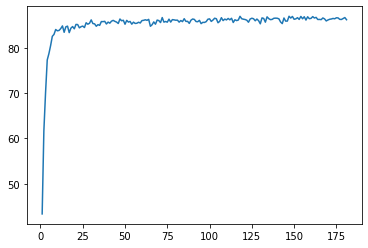

In [10]:
print("Total Run {} epoch(s)".format(Grandstore['total_epoch_run']))

plt.plot(*[range(1,Grandstore['total_epoch_run']+1)],Grandstore['acclog'])
print("Accuracy MIN: {} / MAX: {}".format(Grandstore['minacc'],Grandstore['maxacc']))
print()
print("Top {} performing epochs:".format(TOP_ACCURACY_TRACK))


gstm=Grandstore['topmodels']
for i in range(TOP_ACCURACY_TRACK):
    easy=gstm[TOP_ACCURACY_TRACK-i-1]
    print("#{} epoch {}\t||train_acc {}%\t||test {}%".format(i+1,easy[2],easy[0],easy[1]))
print()
print("Last epoch:")
lsmd=Grandstore['lastmodel']
print("epoch {}\t||train_acc {}%\t||test {}%".format(Grandstore['total_epoch_run'],lsmd[0],lsmd[1]))
      
print()
print("The model has parameters: {}".format(get_n_params(model)))
#grandstore['lastmodel']=((training_accuracy,train_epoch,thisepochtestresult))
# grandstore['lastmodel']=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)

In [11]:
  
f1=open(grandstore_string,"wb")
pickle.dump(Grandstore,f1)
f1.close()

print("writings done!")
print("Files at: "+grandstore_string)

# with open(grandstore_string, 'rb') as file:
#     myvar = pickle.load(file)
#     print(myvar)

writings done!
Files at: grandstore/cifar10_EfficientNetb1_sp20211106191411.pkl
